In [54]:
import re
import os
import pathlib
import json

import plotnine
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_theme(style="darkgrid")


In [55]:
experiment = "01_http_max_throughput"

# Root of the project
project_dir = pathlib.Path().resolve().parent

# Directory containing experiment results
results_dir = (pathlib.Path(project_dir) / "results" / experiment).resolve()
results_dir


PosixPath('/home/richard/projects/mesh-bench/results/01_http_max_throughput')

In [56]:
# Filter columns
required_cols = [
    "StartTime",
    "RequestedQPS",
    "RequestedDuration",
    "ActualQPS",
    "ActualDuration",
    "DurationHistogram",
]


# fortio reports in seconds, convert to miliseconds
multiplier = 1000


# Regex to extract metadata
# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")

"""
Reads a fortio results JSON file, cleans the data and returns
it as a pandas.Series
"""
def clean_fortio_results(results_file: pathlib.Path) -> pd.Series :
    # Read the JSON file as pandas series
    s = pd.read_json(results_file, typ="series")

    # Filter unnecesary columns
    s = s[required_cols]

    # Extract metadata from filename and add it to the series
    matches = re.match(name_re, str(results_file.name))
    s["mesh"] = matches[2]
    s["payload"] = matches[4]
    s["repetition"] = matches[5]

    # Extract nested columns in 'DurationHistogram'
    for key, val in s["DurationHistogram"].items():
        s[key] = val
    s = s.drop(["DurationHistogram", "Percentiles"])

    # Convert obervations from seconds to miliseconds
    s.loc[["Min", "Max", "Sum", "Avg"]] *= multiplier

    # Construct Histogram Bins, Counts and Percentiles
    data = s["Data"]

    s["counts"] = [x["Count"] for x in data]
    s["percentages"] = [x["Percent"] for x in data]

    # Bins (default pd.cut function makes them as categoricals of intervals)
    # https://pandas.pydata.org/docs/reference/api/pandas.Categorical.html
    # https://pandas.pydata.org/docs/reference/api/pandas.Interval.html
    s["categories"]= pd.Categorical([pd.Interval(x["Start"] * multiplier , x["End"] * multiplier) for x in data])
    s["bins"] = [x.left for x in s["categories"]]
    s["bins"].append(s["categories"][-1].right)

    s = s.drop("Data")

    return s


In [57]:
"""
Parse all experiment results:
- Read the JSON files as a flat data structure
- Parse each result file as a individual data frame
- Concatenate all data frames where each row represents an observation
"""



# Regex to extra# 0 -> Full match
# 1 -> Protocol (http/grpc)
# 2 -> Mesh
# 3 -> Requested QPS
# 4 -> Transfer in bytes
# 5 -> Repetitionct dimensions from the filename
name_re = re.compile("^([a-z]+)_([a-z]+)_(\d+|MAX)_(\d+)_(\d+).*json$")


series = []
for root, _, files in os.walk(results_dir, topdown=False):

    print(f"Parsing Experiment results:")
    print(f"Exp: {experiment}\nResults: {len(files)}")

    for file in files:
        # Extract metadata from the result
        matches = re.match(name_re, file)

        # Absolute path of the results file
        p = (pathlib.Path(root) / file).resolve()

        series.append(clean_fortio_results(p))

df = pd.DataFrame(series)
df

Parsing Experiment results:
Exp: 01_http_max_throughput
Results: 5


,StartTime,RequestedQPS,RequestedDuration,ActualQPS,ActualDuration,mesh,payload,repetition,Count,Min,Max,Sum,Avg,StdDev,counts,percentages,categories,bins
0,2022-06-20T13:36:49.964693474Z,max,15m0s,4692.103939,900009474327,istio,0,1,4222938,0.276695,547.578271,2.879545e+07,6.818820,0.008829,"[21, 23100, 203348, 202671, 126892, 59230, 444...","[0.0004972841183080001, 0.5475098142572771, 5....","[(0.276695, 0.30000000000000004], (0.300000000...","[0.276695, 0.30000000000000004, 0.4, 0.5, 0.60..."
1,2022-06-20T15:55:32.807762603Z,max,15m0s,585.924191,900008923245,traefik,0,1,527337,0.312153,361.827879,2.879953e+07,54.613141,0.048186,"[4739, 7647, 13105, 26232, 39199, 37906, 30424...","[0.8986663177436811, 2.348782657010602, 4.8339...","[(0.312153, 1.0], (1.0, 2.0], (2.0, 3.0], (3.0...","[0.312153, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, ..."
2,2022-06-20T18:22:26.802100497Z,max,15m0s,18966.859591,900005291751,cilium,0,1,17070274,0.053272,463.656181,2.879476e+07,1.686836,0.001858,"[86368, 444081, 474495, 466628, 479005, 497708...","[0.50595555759679, 3.107442797930484, 5.887099...","[(0.05327200000000001, 0.1], (0.1, 0.2], (0.2,...","[0.05327200000000001, 0.1, 0.2, 0.300000000000..."
3,2022-06-20T11:07:04.197631346Z,max,15m0s,9281.289737,900008752748,linkerd,0,1,8353242,0.159965,394.333858,2.878994e+07,3.446559,0.003360,"[121, 27933, 63196, 58822, 51749, 45592, 45903...","[0.001448539381476, 0.33584565130520505, 1.092...","[(0.159965, 0.2], (0.2, 0.30000000000000004], ...","[0.159965, 0.2, 0.30000000000000004, 0.4, 0.5,..."
4,2022-06-20T08:32:59.487539804Z,max,15m0s,8746.681700,900002111624,baseline,0,1,7872032,0.047225,168.790170,2.879584e+07,3.657993,0.003416,"[25198, 92183, 97250, 100720, 104478, 110855, ...","[0.32009524351527, 1.491114365388758, 2.726500...","[(0.047225, 0.1], (0.1, 0.2], (0.2, 0.30000000...","[0.047225, 0.1, 0.2, 0.30000000000000004, 0.4,..."


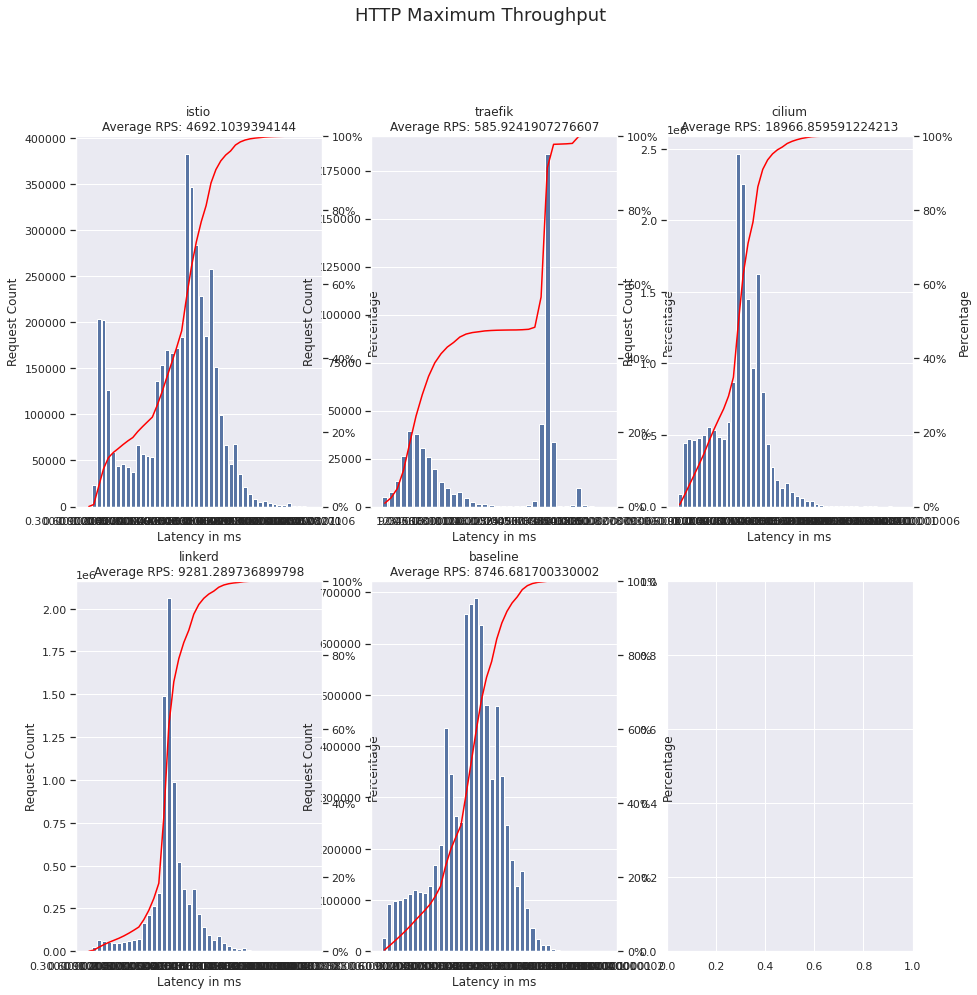

In [62]:
# Create grid of 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,15))

# Makes the axes a one dimensional list
axes = axes.flatten()

# Set figure title
fig.suptitle("HTTP Maximum Throughput", fontsize=18, y=1)


# Plot each row as subplot
for i, row in df.iterrows():

    ax = axes[i]

    # Bar plot showing the binned variables
    sns.barplot(x=row["bins"][1:], y=row["counts"], color="b", ax=ax)

    # # Labels
    ax.set_ylabel("Request Count")
    ax.set_xlabel("Latency in ms")
    ax.set_title(f"{row['mesh']}\nAverage RPS: {row['ActualQPS']}")

    # Logarithmic x axis from 1->50
    # ax.set_xscale("log")
    # ax.set_xlim(1, 15)

    # # ax.set_xticks(range(1, 11))
    # ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())

    # instantiate a second axes that shares the same x-axis
    ax2 = ax.twinx()
    ax2.set_ylabel("Percentage")
    ax2.set_ylim(0, 100)
    ax2.plot(row['percentages'], color="red")
    ax2.set_alpha(0.5)
    ax2.grid(False)
    ax2.yaxis.set_major_formatter(ticker.PercentFormatter())


    # fig.tight_layout()

plt.show()